In [1]:
# import block
import pandas as pd
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

In [2]:
# load raw train data
# parse data
data = None
try:
    with open('data/DebrisFlow.txt', 'r') as f:
        data = f.read()
except:
    print('Error reading file')
if data is not None:
    # split data into lines
    data = data.split('\n')
    # remove empty lines
    data = [line for line in data if line != '']
    # split lines into columns
    data = [line.split('\t') for line in data]
    # convert to numpy array
    data = np.array(data, dtype=np.float64)

In [3]:
# function to plot the model results
def plot_model_results(data: np.ndarray, c_res: list, d_res: list, delta_res: list = None):
    '''
     Plots the model results against the data

     IMPORTANT
     ---------
     provide c, d and delta values in a list even if there is only one value

     Parameters
     ==========
          - data: the data to plot
          - c_res: the c results (slope)
          - d_res: the d results (intercept)
          - delta_res: the delta results (segment number for each data point)

     Returns
     =======
     None
    '''

    fig = plt.figure(figsize=(10, 5))
    if delta_res is None:
      plt.plot(data[:,0], data[:,1], 'k.')
      plt.plot(data[:,0], [c_res[0]*data[i,0]+d_res[0] for i in range(data.shape[0])])
    else:
      colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
      marker_options = ['o', 'v', '^', 's', 'p', '*', '+', 'x']
      segment_list = np.unique(delta_res)
      data_length = data.shape[0]

      y_pred = [[c_res[b]*data[i,0]+d_res[b] for i in range(data_length)] for b in segment_list]
      x_segmented = {b:[] for b in segment_list}
      y_true_segmented = {b:[] for b in segment_list}
      y_pred_segmented = {b:[] for b in segment_list}

      for i in range(data_length):
        segment = delta_res[i]
        x_segmented[segment].append(data[i,0])
        y_true_segmented[segment].append(data[i,1])
        y_pred_segmented[segment].append(c_res[segment]*data[i,0] + d_res[segment])

      # plot the model results
      # plot the data
      for segment in x_segmented.keys():
          plt.plot(x_segmented[segment],y_true_segmented[segment], color='k',linewidth=0, marker=marker_options[segment], markerfacecolor='none')
      for y in y_pred:
          plt.plot(data[:,0],y, linestyle='--', linewidth=0.3, color='k')
      # plot the model results
      for segment in x_segmented.keys():
          plt.plot(x_segmented[segment], y_pred_segmented[segment],color = colors[segment], linestyle='-', linewidth=1.5,
                  label=f'Model Results for segment {segment}')

    plt.xlabel('Volume (1000 m^3)')
    plt.ylabel('Damage (Millions USD)')
    # set the legend
    plt.legend()
    # show the plot
    plt.show()

In [4]:
CBOUND = (min(abs((data[i, 1]-data[j, 1])/(data[i, 0]-data[j, 0]))
              for i in range(data.shape[0]) for j in range(data.shape[0]) if i > j),
          max(abs((data[i, 1]-data[j, 1])/(data[i, 0]-data[j, 0]))
              for i in range(data.shape[0]) for j in range(data.shape[0]) if i > j)
          )

d_lower_list = [data[i, 1] - CBOUND[1]*data[i, 0]
                for i in range(data.shape[0])]
d_lower_list.extend([data[i, 1] - CBOUND[0]*data[i, 0]
                    for i in range(data.shape[0])])

d_upper_list = [data[i, 1] - CBOUND[0]*data[i, 0]
                for i in range(data.shape[0])]
d_upper_list.extend([data[i, 1] - CBOUND[1]*data[i, 0]
                    for i in range(data.shape[0])])

DBOUND = (min(d_lower_list), max(d_upper_list))

print('Bounds for C', CBOUND)
print('Bounds for D', DBOUND)
M1 = [
    max(
        abs(data[i, 1]-CBOUND[1]*data[i, 0]-DBOUND[1]),
        abs(data[i, 1]-CBOUND[0]*data[i, 0]-DBOUND[0]),
        abs(data[i, 1]-CBOUND[0]*data[i, 0]-DBOUND[1]),
        abs(data[i, 1]-CBOUND[1]*data[i, 0]-DBOUND[0]))
    for i in range(data.shape[0])
]

M2=[(DBOUND[1] - DBOUND[0] - data[i,0]*(CBOUND[0]-CBOUND[1])) for i in range(data.shape[0])]

Bounds for C (0.0, 0.2858829471413148)
Bounds for D (-105.77653624065739, 37.16493733)


# Models

### Model 1: Linear Regression
This model represents a simple classic linear regression with mean absolute error as measure for loss.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


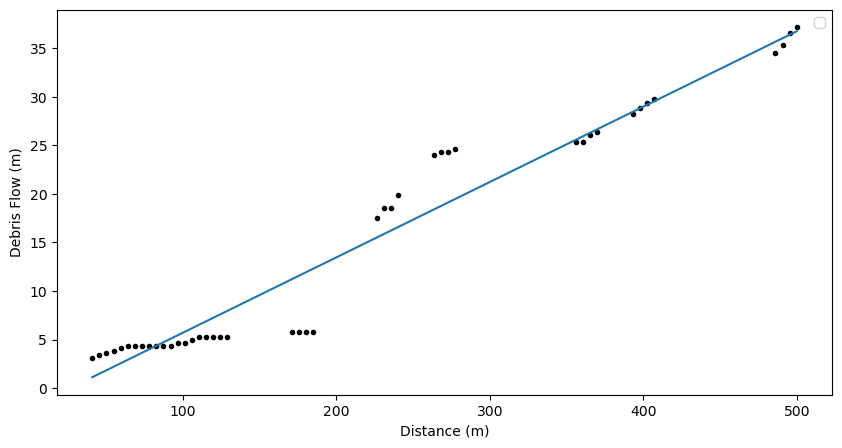

In [5]:
# standard model for linear regression P17top section2
model = pyo.ConcreteModel()

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('c', pyo.Var(domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(domain=pyo.Reals, bounds=DBOUND))

# define the objective function


def obj_func_rule(model):
    return sum((model.ksi[i] for i in model.I))


model.add_component('obj_func', pyo.Objective(
    rule=obj_func_rule, sense=pyo.minimize))

# define the constraints


def constr1_rule(model, i):
    return data[i, 1] - model.c*data[i, 0] - model.d <= model.ksi[i]


model.add_component('constr1', pyo.Constraint(model.I, rule=constr1_rule))


def constr2_rule(model, i):
    return model.c*data[i, 0] + model.d - data[i, 1] <= model.ksi[i]


model.add_component('constr2', pyo.Constraint(model.I, rule=constr2_rule))

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# plot the results
plot_model_results(data, [pyo.value(model.c)], [pyo.value(model.d)])

---
### Model 2: Clusterwise Linear Regression with Sum of absolute differences metric ($L_1$ Norm)

This model is a MILP simultaneously clusters the data and fits a linear regression model to each cluster.

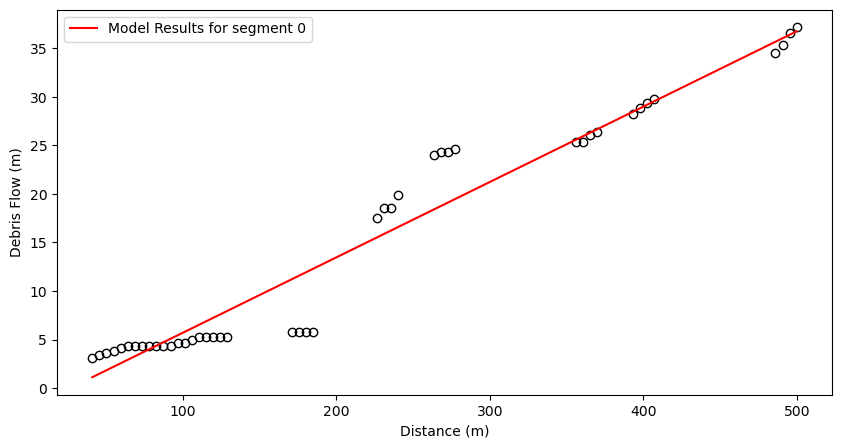

In [6]:
# model 2 P18top section2.1
model = pyo.ConcreteModel()

SEGMENT_COUNT = 1 # max resources limit

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(SEGMENT_COUNT)))

# define the parameters
model.add_component('M', pyo.Param(model.I, initialize=M1))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))

# define the objective functio
def obj_func_rule(model):
    return sum(model.ksi[i] for i in model.I)
model.add_component('obj_func', pyo.Objective(
    rule=obj_func_rule, sense=pyo.minimize))


# define the constraints
# absolute value constraint
def con1_rule(model, i, b):
    return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con1 = pyo.Constraint(model.I, model.B, rule=con1_rule)

def con2_rule(model, i, b):
    return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con2 = pyo.Constraint(model.I, model.B, rule=con2_rule)

# cluster constraint
def con3_rule(model, i):
    return sum(model.delta[i, b] for b in model.B) == 1
model.con3 = pyo.Constraint(model.I, rule=con3_rule)

# minimum number of points in a cluster
def con4_rule(model, b):
    # let n (minimum number of points in a cluster) be 1
    return sum(model.delta[i, b] for i in model.I) >= 1
model.add_component('con4', pyo.Constraint(model.B, rule=con4_rule))

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# plot the results
plot_model_results(data, [pyo.value(model.c[b]) for b in model.B], [pyo.value(model.d[b]) for b in model.B], [
                   b for b in model.B for i in model.I if pyo.value(model.delta[i, b]) == 1])

---
### Model 3: Clusterwise Linear Regression with Maximum Absolute Difference Metric ($L_\infty$ Norm)

This model simplifies the complexity of Model 2 by reformulating the error/distance metric used in the objective function and change necessary constraints accordingly.

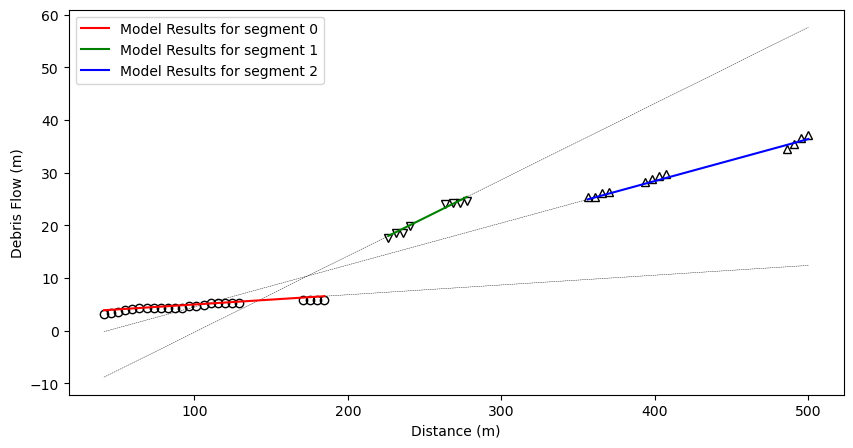

In [7]:
# model 3 P18bottom section2.2
model = pyo.ConcreteModel()

SEGMENT_COUNT = 3 # max resources limit

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(SEGMENT_COUNT)))

# define the parameters
model.add_component('M', pyo.Param(model.I, initialize=M1))

# define the variables
model.add_component('ksi', pyo.Var(domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))

# define the objective functio
def obj_func_rule(model):
    return model.ksi
model.add_component('obj_func', pyo.Objective(
    rule=obj_func_rule, sense=pyo.minimize))


# define the constraints
# absolute value constraint
def con1_rule(model, i, b):
    return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi + model.M[i] * (1 - model.delta[i, b])
model.con1 = pyo.Constraint(model.I, model.B, rule=con1_rule)

def con2_rule(model, i, b):
    return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi + model.M[i] * (1 - model.delta[i, b])
model.con2 = pyo.Constraint(model.I, model.B, rule=con2_rule)

# cluster constraint
def con3_rule(model, i):
    return sum(model.delta[i, b] for b in model.B) == 1
model.con3 = pyo.Constraint(model.I, rule=con3_rule)

# minimum number of points in a cluster
def con4_rule(model, b):
    # let n (minimum number of points in a cluster) be 1
    return sum(model.delta[i, b] for i in model.I) >= 1
model.add_component('con4', pyo.Constraint(model.B, rule=con4_rule))

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

# plot the results
plot_model_results(data, [pyo.value(model.c[b]) for b in model.B], [pyo.value(model.d[b]) for b in model.B], [
                   b for b in model.B for i in model.I if pyo.value(model.delta[i, b]) == 1])

---
### Model 4: Clusterwise Linear Regression with MACD Metric

This model is an extension to Model 3 where the maximum absolute difference is minimized. This results in minimization of the distance to the furthest data which often times is an outlier. Therefore, the model is very sesitive to outliers. Model 4 aims to improve on this by considering the minimization of the sum of maximum distance withing each cluster. Although this is still susceptible to outliers, it provides a better approximation compared to Model 3 while maintaining a decent balance in performance loss.

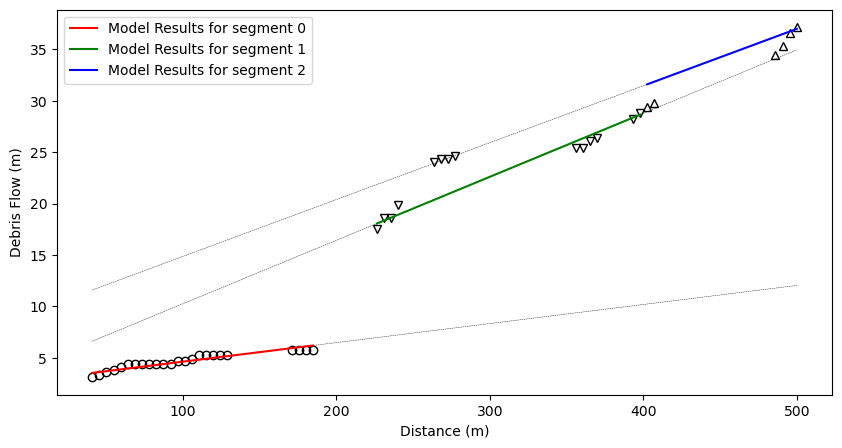

In [8]:
# Model 4 P19top section2.2
model = pyo.ConcreteModel()

SEGMENT_COUNT = 3 # max resources limit

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(SEGMENT_COUNT)))

# define the parameters
model.add_component('M', pyo.Param(model.I, initialize=M1))

# define the variables
model.add_component('ksi', pyo.Var(model.B, domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))

# define the objective functio


def obj_func_rule(model):
    return sum(model.ksi[b] for b in model.B)


model.add_component('obj_func', pyo.Objective(
    rule=obj_func_rule, sense=pyo.minimize))

# define the constraints
# absolute value constraint


def con1_rule(model, i, b):
    return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi[b] + model.M[i] * (1 - model.delta[i, b])


model.con1 = pyo.Constraint(model.I, model.B, rule=con1_rule)


def con2_rule(model, i, b):
    return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi[b] + model.M[i] * (1 - model.delta[i, b])


model.con2 = pyo.Constraint(model.I, model.B, rule=con2_rule)

# cluster constraint


def con3_rule(model, i):
    return sum(model.delta[i, b] for b in model.B) == 1


model.con3 = pyo.Constraint(model.I, rule=con3_rule)

# minimum number of points in a cluste


def con4_rule(model, b):
    # let n (minimum number of points in a cluster) be 1
    return sum(model.delta[i, b] for i in model.I) >= 1


model.add_component('con4', pyo.Constraint(model.B, rule=con4_rule))

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

plot_model_results(data, [pyo.value(model.c[b]) for b in model.B], [pyo.value(model.d[b]) for b in model.B], [b for b in model.B for i in model.I if pyo.value(model.delta[i, b]) == 1])

---
### Model 5: Ordered Clusterwise Linear Regression

Model 3 does not consider the ordering of the data. Meaning, Clusters can form in any shape accross the data. This significantly prolongs the solve times because of many symmetrical solutions.

This can be fixed by taking cluster orders into account; so that all adjacent data points are either withing the same, or adjacent clusters. This sgnificantly reduces the search space size on $\delta_{i,b}$ variables and allows us to use a more robust distance metric (such as $L_1$ norm) as well to achieve better approximations.

However, this comes at the cost of the model's inability to find vertical cluster patterns in the data since all clusters are back-to-back aligned horizontally. Therefore, this model does not work well for data that contain patterns that intersect or stacked clusters.

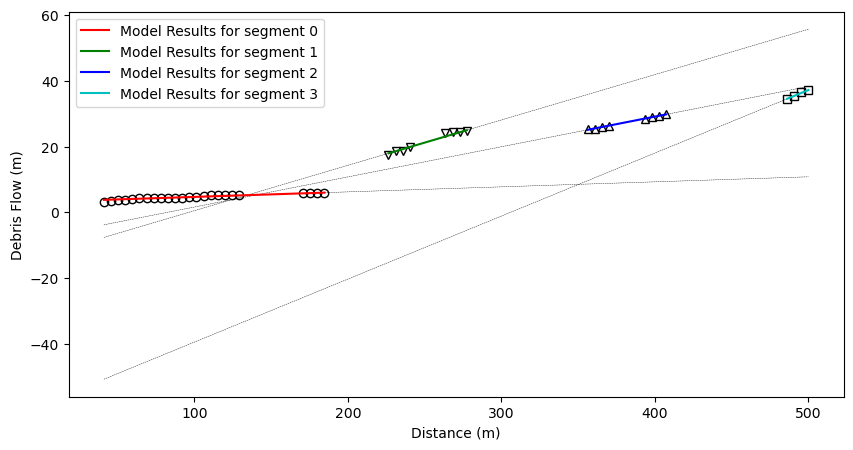

In [9]:
# Model 5 P20top section2.3
model = pyo.ConcreteModel()

SEGMENT_COUNT = 4 # best

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(SEGMENT_COUNT)))

# define the parameters
model.add_component('M', pyo.Param(model.I, initialize=M1))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))

# define the objective functio


def obj_func_rule(model):
    return sum(model.ksi[i] for i in model.I)
model.add_component('obj_func', pyo.Objective(rule=obj_func_rule, sense=pyo.minimize))


def con1b_rule(model, i, b):
    return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con1b = pyo.Constraint(model.I, model.B, rule=con1b_rule)


def con1c_rule(model, i, b):
    return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con1c = pyo.Constraint(model.I, model.B, rule=con1c_rule)

# cluster constraint

def con1d_rule(model, i):
    return sum(model.delta[i, b] for b in model.B) == 1
model.con1d = pyo.Constraint(model.I, rule=con1d_rule)


def con2c_rule(model, i, b):
    if i < (data.shape[0]-1) and b < (SEGMENT_COUNT-1):
        return model.delta[i+1, b+1] <= model.delta[i, b] + model.delta[i, b+1]
    else:
        return pyo.Constraint.Skip
model.con2c = pyo.Constraint(model.I, model.B, rule=con2c_rule)


def con2d_rule(model, i):
    if i < (data.shape[0]-1):
        return model.delta[i+1, 0] <= model.delta[i, 0]
    else:
        return pyo.Constraint.Skip
model.con2d = pyo.Constraint(model.I, rule=con2d_rule)


def con2e_rule(model, i):
    if i < (data.shape[0]-1):
        return model.delta[i, SEGMENT_COUNT-1] <= model.delta[i+1, SEGMENT_COUNT-1]
    else:
        return pyo.Constraint.Skip
model.con2e = pyo.Constraint(model.I, rule=con2e_rule)

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)

plot_model_results(data, [pyo.value(model.c[b]) for b in model.B], [pyo.value(model.d[b]) for b in model.B], [
                   b for b in model.B for i in model.I if pyo.value(model.delta[i, b]) == 1])

---
### Model 6: Piecewise Convex Linear Regression

This model approaches the problem from a different prespective. It tries to fit a continuous piecewise linear function to the data. This is way more computationally efficient than fitting a non-linear function to the data. In this particular model, it is required for the PWLF to be convex. [_[Toriello, Vielma]_](http://refhub.elsevier.com/S0166-218X(23)00088-4/sb48)

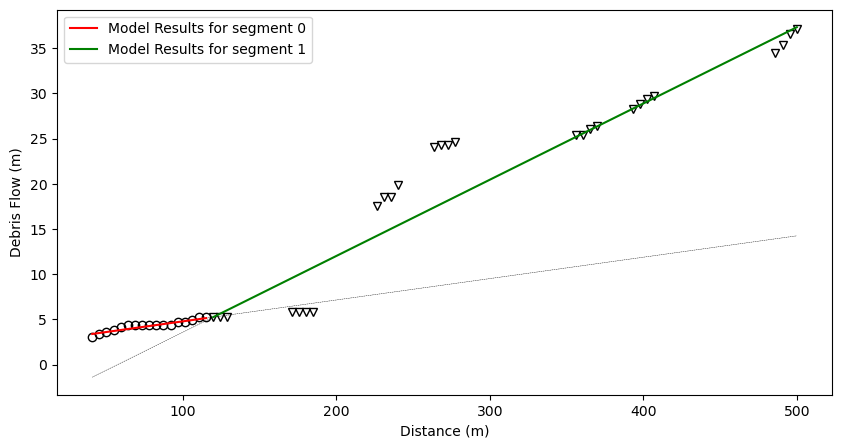

In [10]:
# model 6 P20bottom section2.4
model = pyo.ConcreteModel()

SEGMENT_COUNT = 3 # max resources limit

# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(SEGMENT_COUNT-1)))

# define the parameters
model.add_component('M', pyo.Param(model.I, initialize=M1))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))

# define the objective functio
def obj_func_rule(model):
    return sum(model.ksi[i] for i in model.I)
model.add_component('obj_func', pyo.Objective(rule=obj_func_rule, sense=pyo.minimize))


def con1_rule(model, i, b):
        return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi[i] + model.M[i] * (1 - model.delta[i, b])
model.con1 = pyo.Constraint(model.I, model.B, rule=con1_rule)


def con2_rule(model, i, b):
        return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi[i]
model.con2 = pyo.Constraint(model.I, model.B, rule=con2_rule)

# cluster constraint
def con3_rule(model, i):
    return sum(model.delta[i, b] for b in model.B ) == 1
model.con3 = pyo.Constraint(model.I, rule=con3_rule)


def con4_rule(model, b):
    if b < (SEGMENT_COUNT-2):
        return model.c[b] <= model.c[b+1]
    else:
        return pyo.Constraint.Skip
model.con4 = pyo.Constraint(model.B, rule=con4_rule)

# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)


plot_model_results(data, [pyo.value(model.c[b]) for b in model.B ], [pyo.value(model.d[b]) for b in model.B ], [
                   b for b in model.B for i in model.I if pyo.value(model.delta[i, b]) == 1])

---
### Model 7: Piecewise Linear Regression

> In this model we assume that the data are strictly ordered.

This model extends on model 5 and introduces a few concepts.
* First, it requires that any two adjacent segments to intersect at the break point.
* This model does not require the PWLF to be convex. To achieve this, it introduces two sets of constraints, one for when the gradient increases and one for when it decreases and controls whether each of them are active using a binary variable $\gamma_b$.

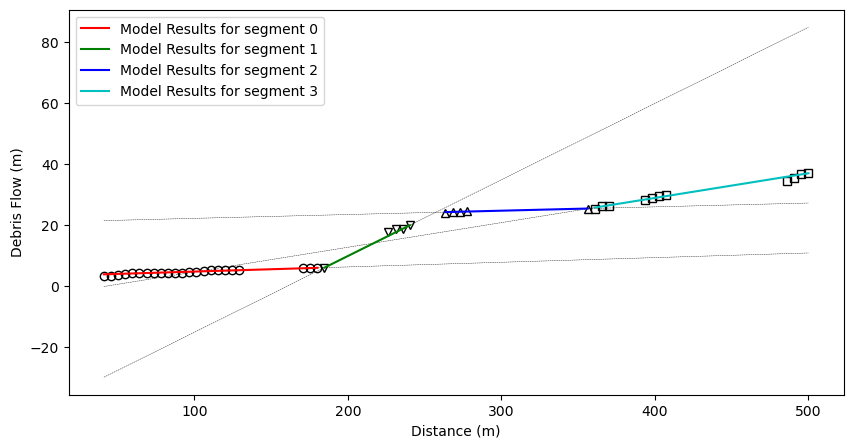

In [11]:
#Model 7 P21bottom section2.4
model = pyo.ConcreteModel()

NSEGMENTS = 5 # best
# sets
model.add_component('I', pyo.Set(initialize=range(data.shape[0])))
model.add_component('B', pyo.Set(initialize=range(NSEGMENTS)))

# define the parameters
model.add_component('M1', pyo.Param(model.I, initialize=M1))
model.add_component('M2', pyo.Param(model.I, initialize=M2))

# define the variables
model.add_component('ksi', pyo.Var(model.I, domain=pyo.NonNegativeReals))
model.add_component('delta', pyo.Var(model.I, model.B, domain=pyo.Binary))
model.add_component('gamma', pyo.Var(model.B, domain=pyo.Binary))
model.add_component('delta_pos', pyo.Var(model.I,model.B, domain=pyo.NonNegativeReals, bounds=(0,1)))
model.add_component('delta_neg', pyo.Var(model.I,model.B, domain=pyo.NonNegativeReals, bounds=(0,1)))
model.add_component('c', pyo.Var(model.B, domain=pyo.Reals, bounds=CBOUND))
model.add_component('d', pyo.Var(model.B, domain=pyo.Reals, bounds=DBOUND))


# define the objective functio
def obj_func_rule(model):
    return sum(model.ksi[i] for i in model.I)
model.add_component('obj_func', pyo.Objective(rule=obj_func_rule, sense=pyo.minimize))


def con1b_rule(model, i, b):
  if b < (NSEGMENTS-1):
    return data[i, 1] - (model.c[b] * data[i, 0] + model.d[b]) <= model.ksi[i] + model.M1[i] * (1 - model.delta[i, b])
  else:
    return pyo.Constraint.Skip
model.con1b = pyo.Constraint(model.I, model.B, rule=con1b_rule)


def con1c_rule(model, i, b):
  if b < (NSEGMENTS-1):
    return model.c[b] * data[i, 0] + model.d[b] - data[i, 1] <= model.ksi[i] + model.M1[i] * (1 - model.delta[i, b])
  else:
    return pyo.Constraint.Skip
model.con1c = pyo.Constraint(model.I, model.B, rule=con1c_rule)

# cluster constraint

def con1d_rule(model, i):
    return sum(model.delta[i, b] for b in model.B if b<NSEGMENTS-1) == 1
model.con1d = pyo.Constraint(model.I, rule=con1d_rule)


def con2c_rule(model, i, b):
    if i < (data.shape[0]-1) and  b < (NSEGMENTS-1):
        return model.delta[i+1, b+1] <= model.delta[i, b] + model.delta[i, b+1]
    else:
        return pyo.Constraint.Skip
model.con2c = pyo.Constraint(model.I, model.B, rule=con2c_rule)


def con2d_rule(model, i):
    if i < (data.shape[0]-1):
        return model.delta[i+1, 0] <= model.delta[i, 0]
    else:
        return pyo.Constraint.Skip
model.con2d = pyo.Constraint(model.I, rule=con2d_rule)


def con2e_rule(model, i):
    if i < (data.shape[0]-1):
        return model.delta[i, NSEGMENTS-1] <= model.delta[i+1, NSEGMENTS-1]
    else:
        return pyo.Constraint.Skip
model.con2e = pyo.Constraint(model.I, rule=con2e_rule)


def con3d_rule(model, i,b):
    if i < (data.shape[0]-1) and b < (NSEGMENTS-2):
        return model.delta[i,b] + model.delta[i+1,b+1] + model.gamma[b] - 2 <= model.delta_pos[i,b]
    else:
        return pyo.Constraint.Skip
model.con3d = pyo.Constraint(model.I,model.B, rule=con3d_rule)


def con3e_rule(model, i,b):
    if i < (data.shape[0]-1) and b < (NSEGMENTS-2):
        return model.delta[i,b] + model.delta[i+1,b+1] + 1 - model.gamma[b] - 2 <= model.delta_neg[i,b]
    else:
        return pyo.Constraint.Skip
model.con3e = pyo.Constraint(model.I,model.B, rule=con3e_rule)

def con3f_rule(model, i,b):
    if i < (data.shape[0]-1) and b < (NSEGMENTS-2):
        return model.d[b+1] - model.d[b] >=  data[i,0]*(model.c[b] - model.c[b+1]) - model.M2[i]*(1 - model.delta_pos[i,b])
    else:
        return pyo.Constraint.Skip
model.con3f = pyo.Constraint(model.I,model.B, rule=con3f_rule)


def con3g_rule(model, i,b):
    if i < (data.shape[0]-1) and b < (NSEGMENTS-2):
        return model.d[b+1] - model.d[b] <=  data[i+1,0]*(model.c[b] - model.c[b+1]) + model.M2[i+1]*(1 - model.delta_pos[i,b])
    else:
        return pyo.Constraint.Skip
model.con3g = pyo.Constraint(model.I,model.B, rule=con3g_rule)


def con3h_rule(model, i,b):
    if i < (data.shape[0]-1) and b < (NSEGMENTS-2):
        return model.d[b+1] - model.d[b] <=  data[i,0]*(model.c[b] - model.c[b+1]) + model.M2[i]*(1 - model.delta_neg[i,b])
    else:
        return pyo.Constraint.Skip
model.con3h = pyo.Constraint(model.I,model.B, rule=con3h_rule)


def con3i_rule(model, i,b):
    if i < (data.shape[0]-1) and b < (NSEGMENTS-2):
        return model.d[b+1] - model.d[b] >=  data[i+1,0]*(model.c[b] - model.c[b+1]) - model.M2[i+1]*(1 - model.delta_neg[i,b])
    else:
        return pyo.Constraint.Skip
model.con3i = pyo.Constraint(model.I,model.B, rule=con3i_rule)


# solve the model
solver = pyo.SolverFactory('glpk')
results = solver.solve(model)


plot_model_results(data, [pyo.value(model.c[b]) for b in model.B if b<NSEGMENTS-1], [pyo.value(model.d[b]) for b in model.B if b<NSEGMENTS-1], [
                   b for b in model.B for i in model.I if b<NSEGMENTS-1 and pyo.value(model.delta[i, b]) == 1])